# Customer Churn Prediction & ROI-Backend Retention Playbook

## Project Overview
This notebook implements machine learning models to predict customer churn in the telecom industry.

**Objectives:**
- Analyze customer behavior patterns
- Build predictive models for churn
- Identify key factors driving churn
- Provide actionable retention strategies


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
df = pd.read_csv('Telco-Customer-Churn.csv') 

print(f"Shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Shape: (7043, 21)
Rows: 7043, Columns: 21


In [4]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
print("="*60)
print("DATASET INFORMATION")
print("="*60)
df.info()

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043

In [ ]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [9]:
# Check for missing values
print("Missing Values Count:")
print(df.isnull().sum())


Missing Values Count:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Churn Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Percentage:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


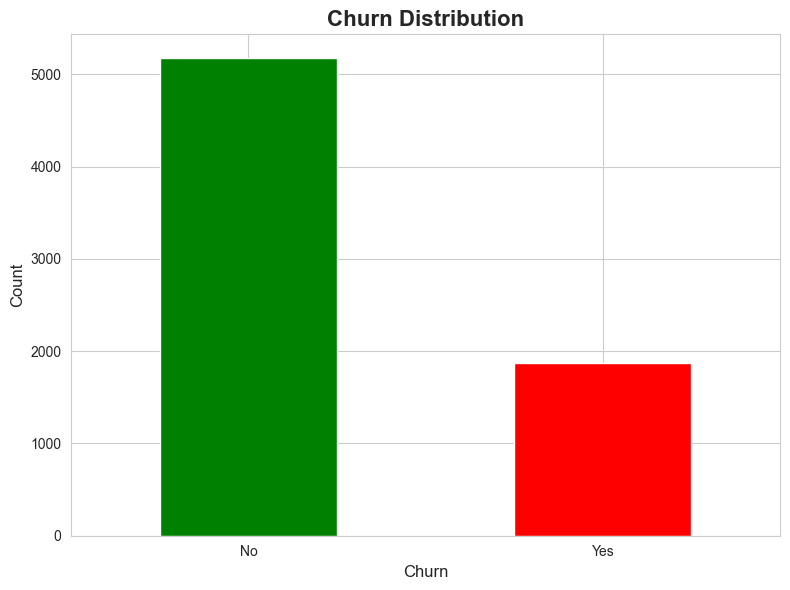

In [10]:
# Analyze churn distribution
print("Churn Distribution:")
print(df['Churn'].value_counts())

print("\n" + "="*50)
churn_percentage = df['Churn'].value_counts(normalize=True) * 100
print("Churn Percentage:")
print(churn_percentage)

# Visualize churn distribution
plt.figure(figsize=(8, 6))
df['Churn'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Churn Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [18]:
# Strip spaces and replace empty strings with NaN
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)

# Check if any NaN appeared (these were the blank spaces)
print("Blank entries found:", df['TotalCharges'].isna().sum())

# Convert safely to float
df['TotalCharges'] = df['TotalCharges'].astype('float64')
df['MonthlyCharges'] = df['MonthlyCharges'].astype('float64')

# Optional: if you want to handle those NaNs (e.g., set them to 0 or median)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Verify
print(df[['MonthlyCharges', 'TotalCharges']].dtypes)


Blank entries found: 11
MonthlyCharges    float64
TotalCharges      float64
dtype: object


In [27]:
# Fill NaN values in TotalCharges with median
median_total = df['TotalCharges'].median()
df['TotalCharges'] = df['TotalCharges'].fillna(median_total)

# Verify
print(f"Median value used for filling: {median_total}")
print(df[['MonthlyCharges', 'TotalCharges']].dtypes)
print("Remaining NaN after fill:", df['TotalCharges'].isna().sum())

Median value used for filling: 1394.55
MonthlyCharges    float64
TotalCharges      float64
dtype: object
Remaining NaN after fill: 0


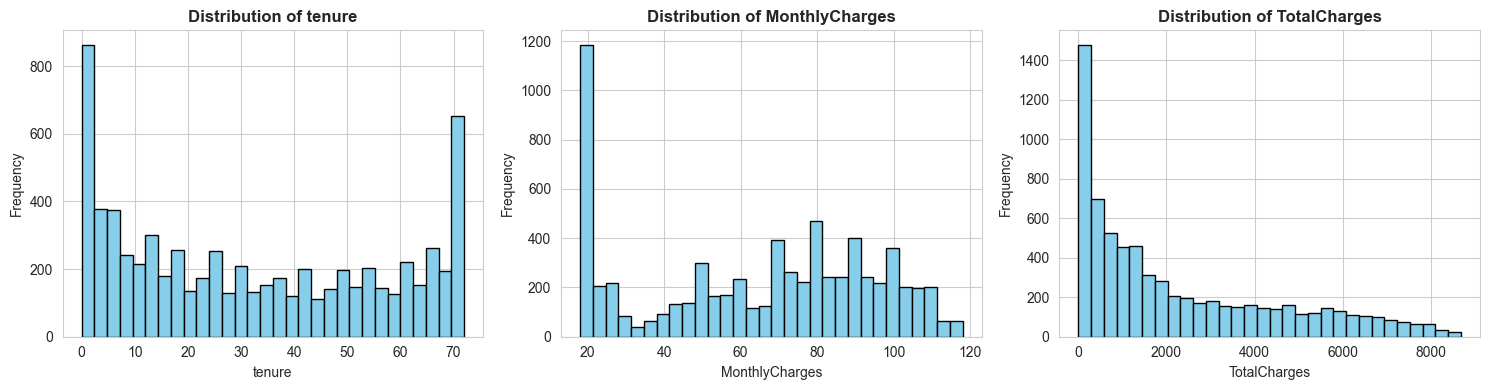

In [28]:
# Analyze numerical features
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col], bins=30, color='skyblue', edgecolor='black')
    axes[idx].set_title(f'Distribution of {col}', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

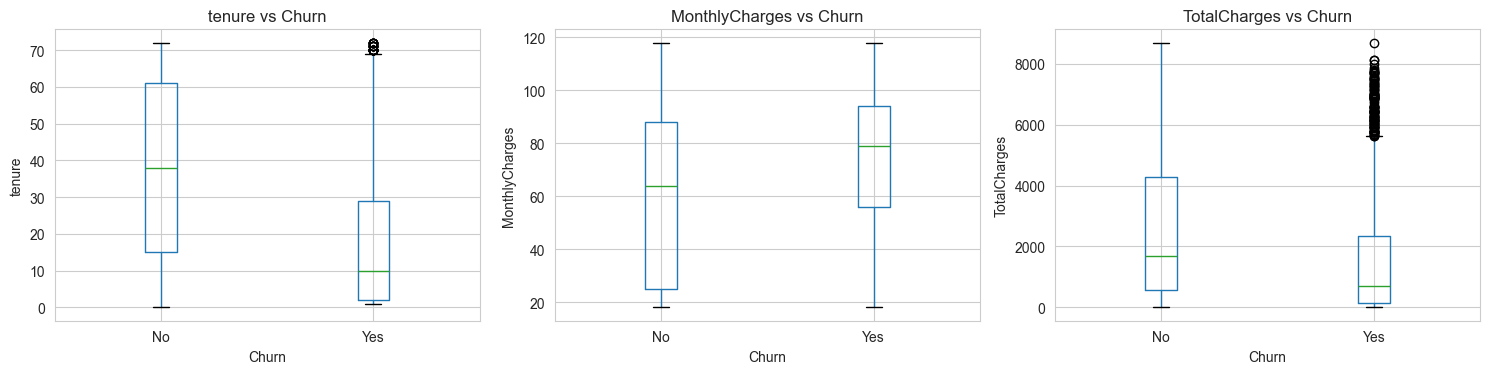

In [20]:
# Analyze numerical features against churn
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, col in enumerate(numerical_cols):
    df.boxplot(column=col, by='Churn', ax=axes[idx])
    axes[idx].set_title(f'{col} vs Churn')
    axes[idx].set_xlabel('Churn')
    axes[idx].set_ylabel(col)

plt.suptitle('')
plt.tight_layout()
plt.show()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [22]:
# List all categorical columns
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                    'PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

# Display unique values for each categorical column
for col in categorical_cols:
    print(f"\n{col} - Unique Values:")
    print(df[col].value_counts())
    print("-" * 40)


gender - Unique Values:
gender
Male      3555
Female    3488
Name: count, dtype: int64
----------------------------------------

SeniorCitizen - Unique Values:
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
----------------------------------------

Partner - Unique Values:
Partner
No     3641
Yes    3402
Name: count, dtype: int64
----------------------------------------

Dependents - Unique Values:
Dependents
No     4933
Yes    2110
Name: count, dtype: int64
----------------------------------------

PhoneService - Unique Values:
PhoneService
Yes    6361
No      682
Name: count, dtype: int64
----------------------------------------

MultipleLines - Unique Values:
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
----------------------------------------

InternetService - Unique Values:
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64
-----------------------

In [23]:
# Calculate churn rate for key categorical features
key_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                'Contract', 'InternetService', 'PaymentMethod']

for feature in key_features:
    churn_rate = df.groupby(feature)['Churn'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100)
    print(f"\nChurn Rate by {feature}:")
    print(churn_rate.sort_values(ascending=False))
    print("-" * 50)


Churn Rate by gender:
gender
Female    26.920872
Male      26.160338
Name: Churn, dtype: float64
--------------------------------------------------

Churn Rate by SeniorCitizen:
SeniorCitizen
1    41.681261
0    23.606168
Name: Churn, dtype: float64
--------------------------------------------------

Churn Rate by Partner:
Partner
No     32.957979
Yes    19.664903
Name: Churn, dtype: float64
--------------------------------------------------

Churn Rate by Dependents:
Dependents
No     31.279140
Yes    15.450237
Name: Churn, dtype: float64
--------------------------------------------------

Churn Rate by Contract:
Contract
Month-to-month    42.709677
One year          11.269518
Two year           2.831858
Name: Churn, dtype: float64
--------------------------------------------------

Churn Rate by InternetService:
InternetService
Fiber optic    41.892765
DSL            18.959108
No              7.404980
Name: Churn, dtype: float64
--------------------------------------------------

Ch

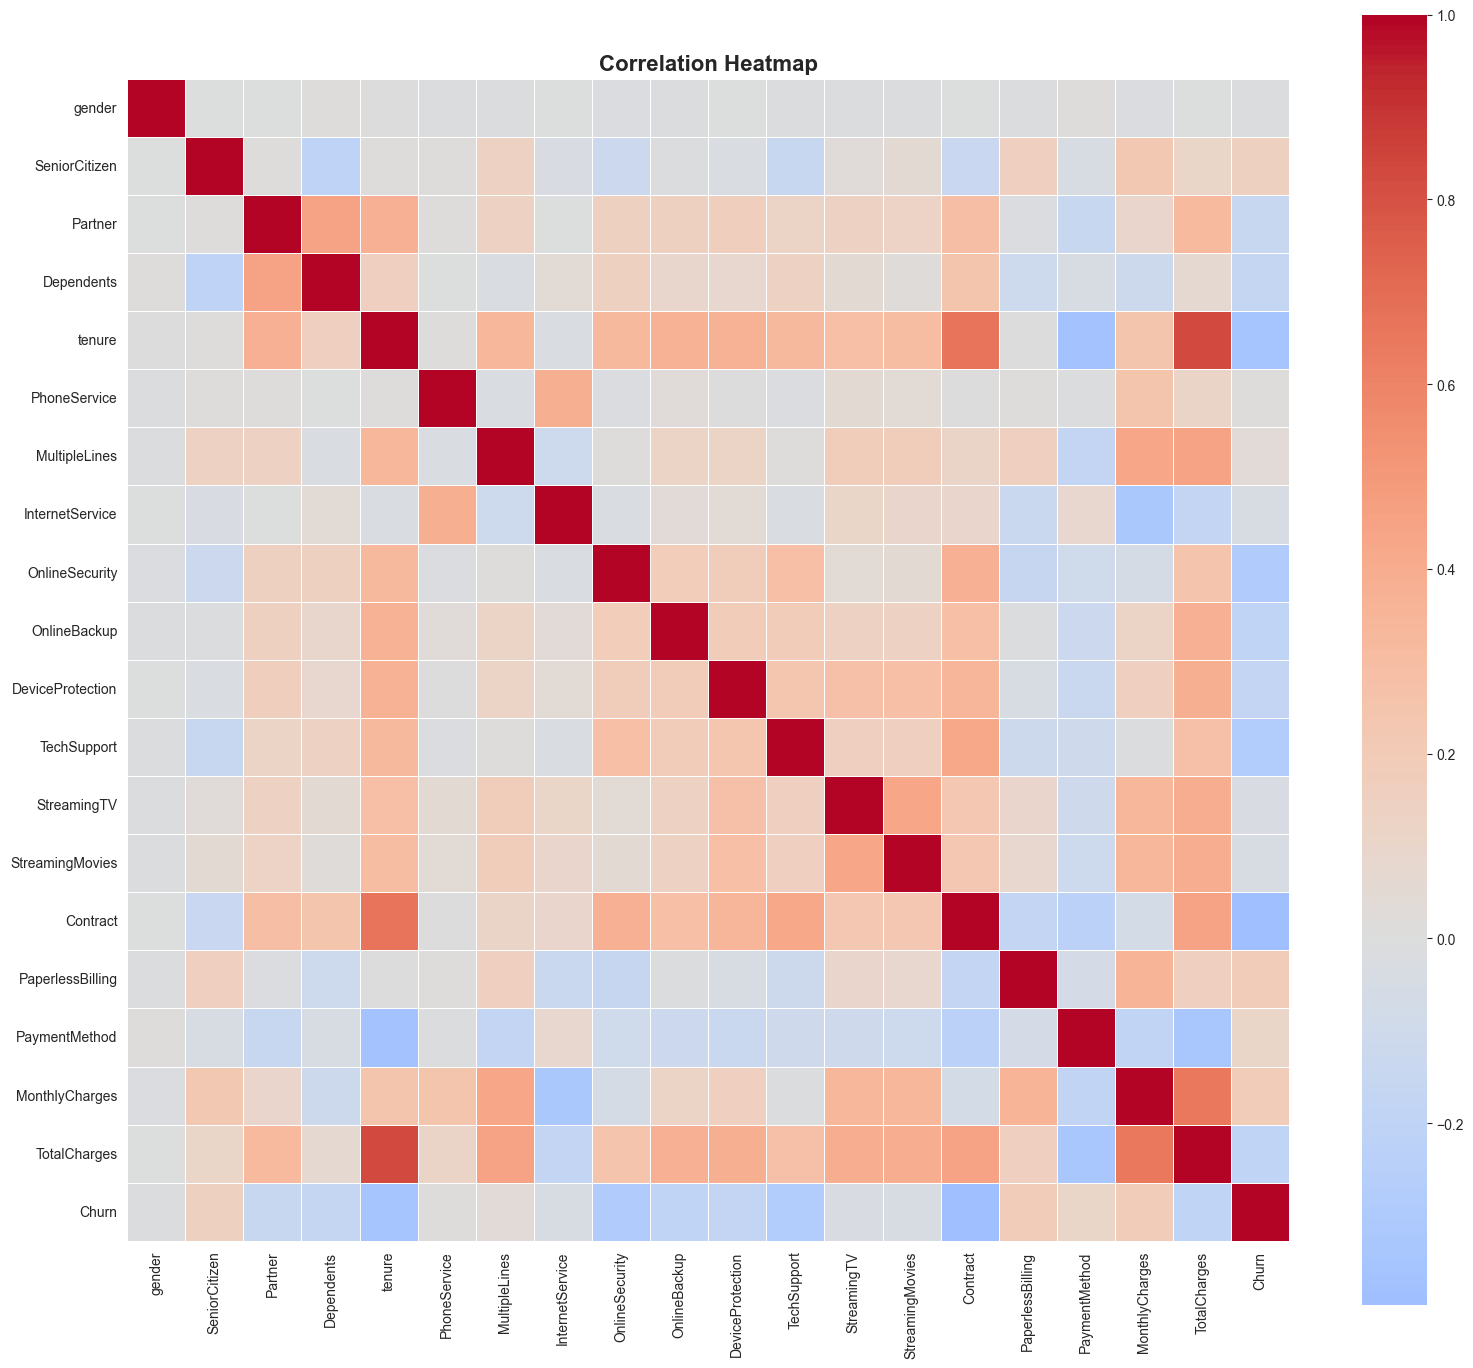


Top Features Correlated with Churn:
Churn               1.000000
MonthlyCharges      0.193422
PaperlessBilling    0.191825
SeniorCitizen       0.150889
PaymentMethod       0.107062
MultipleLines       0.038037
PhoneService        0.011942
gender             -0.008612
StreamingTV        -0.036581
StreamingMovies    -0.038492
Name: Churn, dtype: float64


In [24]:
# Create a copy for encoding
df_encoded = df.copy()

# Encode categorical variables for correlation
label_encoders = {}
for col in df_encoded.select_dtypes(include='object').columns:
    if col != 'customerID':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le

# Remove customerID for correlation
df_corr = df_encoded.drop('customerID', axis=1, errors='ignore')

# Calculate correlation matrix
correlation_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Show top correlations with Churn
print("\nTop Features Correlated with Churn:")
churn_corr = correlation_matrix['Churn'].sort_values(ascending=False)
print(churn_corr.head(10))

In [26]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ChargesPerMonth,TenureGroup
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.0,29.85,No,14.925000,0-1 Year
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.0,1889.50,No,53.985714,2-4 Years
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.0,108.15,Yes,36.050000,0-1 Year
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.0,1840.75,No,40.016304,2-4 Years
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.0,151.65,Yes,50.550000,0-1 Year


## Feature Engineering

In [33]:
# Create new features
df['ChargesPerMonth'] = df['TotalCharges'] / (df['tenure'] + 1)
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], 
                            labels=['0-1 Year', '1-2 Years', '2-4 Years', '4+ Years'])

print("New features created:")
print(df[['tenure', 'TenureGroup', 'ChargesPerMonth']].head(10))

New features created:
   tenure TenureGroup  ChargesPerMonth
0       1    0-1 Year        14.925000
1      34   2-4 Years        53.985714
2       2    0-1 Year        36.050000
3      45   2-4 Years        40.016304
4       2    0-1 Year        50.550000
5       8    0-1 Year        91.166667
6      22   1-2 Years        84.756522
7      10    0-1 Year        27.445455
8      28   2-4 Years       105.036207
9      62    4+ Years        55.364286


In [30]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns (from your summary)
categorical_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

# Initialize the encoder
le = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

print("Label encoding applied successfully to all categorical columns.")
print(df[categorical_cols].head())


Label encoding applied successfully to all categorical columns.
   gender  SeniorCitizen  Partner  Dependents  PhoneService  MultipleLines  \
0       0              0        1           0             0              1   
1       1              0        0           0             1              0   
2       1              0        0           0             1              0   
3       1              0        0           0             0              1   
4       0              0        0           0             1              0   

   InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
0                0               0             2                 0   
1                0               2             0                 2   
2                0               2             2                 0   
3                0               2             0                 2   
4                1               0             0                 0   

   TechSupport  StreamingTV  StreamingMovies  

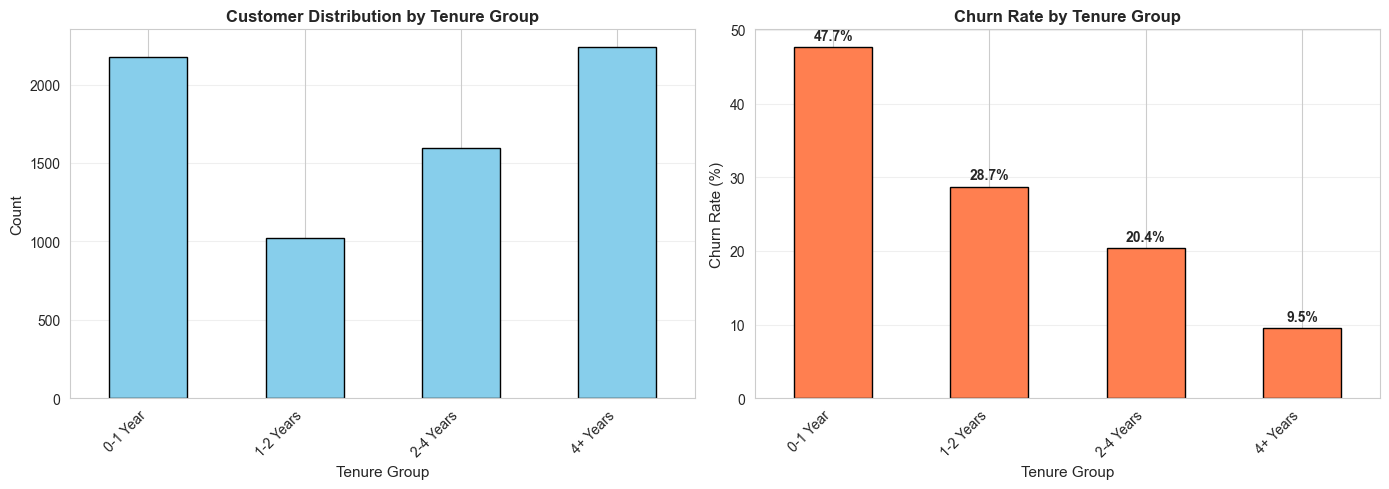

In [32]:
# Visualize tenure groups and churn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Tenure group distribution
df['TenureGroup'].value_counts().sort_index().plot(kind='bar', ax=axes[0], 
                                                     color='skyblue', edgecolor='black')
axes[0].set_title('Customer Distribution by Tenure Group', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Tenure Group', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Compute churn rate by tenure group (exclude missing TenureGroup)
tenure_churn = (
    df.dropna(subset=['TenureGroup'])
      .groupby('TenureGroup')['Churn']
      .apply(lambda x: (x == 'Yes').mean() * 100)
      .sort_index()
)

# If TenureGroup categories are known, ensure consistent order (optional)
ordered_groups = ['0-1 Year', '1-2 Years', '2-4 Years', '4+ Years']
tenure_churn = tenure_churn.reindex([g for g in ordered_groups if g in tenure_churn.index])

# If there is no data to plot, show a message instead of erroring
if tenure_churn.empty:
    axes[1].text(0.5, 0.5, 'No TenureGroup / Churn data available', ha='center', va='center')
    axes[1].set_axis_off()
else:
    # Churn rate by tenure group
    tenure_churn.plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
    axes[1].set_title('Churn Rate by Tenure Group', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Tenure Group', fontsize=11)
    axes[1].set_ylabel('Churn Rate (%)', fontsize=11)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)

    # Add percentage labels
    for i, v in enumerate(tenure_churn):
        axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [44]:
print("="*60)
print("PREPARING DATA FOR MACHINE LEARNING")
print("="*60)

df_ml = df.drop(['customerID', 'TenureGroup'], axis=1, errors='ignore')


X = df_ml.drop('Churn', axis=1)
y = df_ml['Churn']

print(f"\n✅ Features shape: {X.shape}")
print(f"✅ Target shape: {y.shape}")

print("\n" + "="*60)
print("TARGET DISTRIBUTION")
print("="*60)
print(y.value_counts())
print(f"\nChurn Rate: {(y == 'Yes').sum() / len(y) * 100:.2f}%")

PREPARING DATA FOR MACHINE LEARNING

✅ Features shape: (7043, 20)
✅ Target shape: (7043,)

TARGET DISTRIBUTION
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: 26.54%


In [ ]:
print(y.unique())


['No' 'Yes']


In [47]:
# Now map to 0 and 1
y = y.map({'Yes': 1, 'No': 0})

In [49]:
print(y.unique())


[0 1]


In [52]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Split the data before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Before SMOTE:")
print(y_train.value_counts())

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(y_train_resampled.value_counts())

print(f"\nOriginal training shape: {X_train.shape}, {y_train.shape}")
print(f"Resampled training shape: {X_train_resampled.shape}, {y_train_resampled.shape}")


Before SMOTE:
Churn
0    4139
1    1495
Name: count, dtype: int64

After SMOTE:
Churn
0    4139
1    4139
Name: count, dtype: int64

Original training shape: (5634, 20), (5634,)
Resampled training shape: (8278, 20), (8278,)


In [53]:
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("\nTraining set target distribution:")
print(y_train.value_counts())
print("\nTest set target distribution:")
print(y_test.value_counts())

Training set size: (5634, 20)
Test set size: (1409, 20)

Training set target distribution:
Churn
0    4139
1    1495
Name: count, dtype: int64

Test set target distribution:
Churn
0    1035
1     374
Name: count, dtype: int64


## Feature Scaling

In [54]:
# Initialize scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Scaled training data:")
print(X_train_scaled.head())

Scaled training data:
        gender  SeniorCitizen   Partner  Dependents    tenure  PhoneService  \
3738  0.994336      -0.441773 -0.969234   -0.651557  0.102371     -3.013090   
3151  0.994336      -0.441773  1.031742    1.534786 -0.711743      0.331885   
4860  0.994336      -0.441773  1.031742    1.534786 -0.793155     -3.013090   
3867 -1.005696      -0.441773  1.031742   -0.651557 -0.263980      0.331885   
3810  0.994336      -0.441773  1.031742    1.534786 -1.281624      0.331885   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
3738       0.055253        -1.183116       -0.919558     -1.040535   
3151      -0.999989         0.174179        1.403666     -1.040535   
4860       0.055253        -1.183116        1.403666      1.227308   
3867      -0.999989        -1.183116       -0.919558      1.227308   
3810      -0.999989        -1.183116       -0.919558     -1.040535   

      DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
373

## Logistic Regression

In [55]:
# Train Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred_log = log_reg.predict(X_test_scaled)
y_pred_proba_log = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("="*60)
print("LOGISTIC REGRESSION RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_log):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_log):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_log):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_log):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_log):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_log))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))

LOGISTIC REGRESSION RESULTS
Accuracy: 0.8062
Precision: 0.6678
Recall: 0.5374
F1-Score: 0.5956
ROC-AUC: 0.8460

Confusion Matrix:
[[935 100]
 [173 201]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.67      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409



## Decision Tree

In [56]:
# Train Decision Tree
dt_clf = DecisionTreeClassifier(random_state=42, max_depth=10)
dt_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_dt = dt_clf.predict(X_test_scaled)
y_pred_proba_dt = dt_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("="*60)
print("DECISION TREE RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dt):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dt):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_dt):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

DECISION TREE RESULTS
Accuracy: 0.7729
Precision: 0.5794
Recall: 0.5267
F1-Score: 0.5518
ROC-AUC: 0.7677

Confusion Matrix:
[[892 143]
 [177 197]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1035
           1       0.58      0.53      0.55       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.70      1409
weighted avg       0.77      0.77      0.77      1409



## Random Forest

In [57]:
# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_rf = rf_clf.predict(X_test_scaled)
y_pred_proba_rf = rf_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("="*60)
print("RANDOM FOREST RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

RANDOM FOREST RESULTS
Accuracy: 0.7991
Precision: 0.6608
Recall: 0.5000
F1-Score: 0.5693
ROC-AUC: 0.8343

Confusion Matrix:
[[939  96]
 [187 187]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



## Gradient Boosting

In [58]:
# Train Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=5)
gb_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_gb = gb_clf.predict(X_test_scaled)
y_pred_proba_gb = gb_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("="*60)
print("GRADIENT BOOSTING RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_gb):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_gb):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_gb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

GRADIENT BOOSTING RESULTS
Accuracy: 0.7977
Precision: 0.6540
Recall: 0.5053
F1-Score: 0.5701
ROC-AUC: 0.8339

Confusion Matrix:
[[935 100]
 [185 189]]

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



## XGBoost Classifier

In [59]:
from xgboost import XGBClassifier
# Train XGBoost Classifier
xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # suppress warning
)

xgb_clf.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = xgb_clf.predict(X_test_scaled)
y_pred_proba_xgb = xgb_clf.predict_proba(X_test_scaled)[:, 1]

# Evaluate model
print("="*60)
print("XGBOOST RESULTS")
print("="*60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBOOST RESULTS
Accuracy:  0.8013
Precision: 0.6556
Recall:    0.5294
F1-Score:  0.5858
ROC-AUC:   0.8442

Confusion Matrix:
[[931 104]
 [176 198]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.53      0.59       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

